In [1]:
from train import MCTS_HYPERPARAMETERS, load_from_checkpoint, collect_episode, train, rotate_training_examples
import torch
from model_3d import MonteCarlo3d
from utils import input_to_tensor_3d
import torch.multiprocessing as mp
from train import save_checkpoint, load_from_checkpoint, ReplayMemory, MetricsHistory

In [2]:
MODEL_TO_LOAD = "" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True

# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hyperparameters = MCTS_HYPERPARAMETERS() # use kwargs to specify non-default values


In [3]:
if MODEL_TO_LOAD:
    _, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, MonteCarlo3d, load_replay_memory=LOAD_REPLAY_MEMORY)
else:
    model = MonteCarlo3d()
    replay_memory = ReplayMemory(hyperparameters.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay)
    metrics_history = MetricsHistory()
    run_tag = 'no_prepopulate'     
    episode = 0
    hyperparameters.replay_memory_size = 480000
    hyperparameters.minibatch_size = 2048
    hyperparameters.weight_decay = 0.001    
    
NUM_PROCS = 7

In [4]:
hyperparameters

MCTS_HYPERPARAMETERS(lr=0.0005, weight_decay=0.001, minibatch_size=2048, replay_memory_size=480000, num_mcts_train_evals=500, num_mcts_test_evals=1000, num_episodes=1000, checkpoint_every=100, mcts_c_puct=12, mcts_tau=1.0)

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/marshingjay/opt/anaconda3/envs/python38/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/marshingjay/opt/anaconda3/envs/python38/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/marshingjay/opt/anaconda3/envs/python38/lib/python3.8/multiprocessing/pool.py", line 592, in _handle_results
    cache[job]._set(i, obj)
  File "/Users/marshingjay/opt/anaconda3/envs/python38/lib/python3.8/multiprocessing/pool.py", line 776, in _set
    self._callback(self._value)
  File "/var/folders/bd/sfd5qw2j27v1b3ht5zx176l00000gn/T/ipykernel_58699/2338117864.py", line 16, in enque_and_train
  File "/Users/marshingjay/Repos/2048_dqn/train.py", line 85, in plot_history
    if pl == 'rewards':
ValueError: Moving window (=100) must between 1 and 2, inclusive
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-9:
Traceback (most recent

AssertionError: Cannot have cache with result_hander not alive

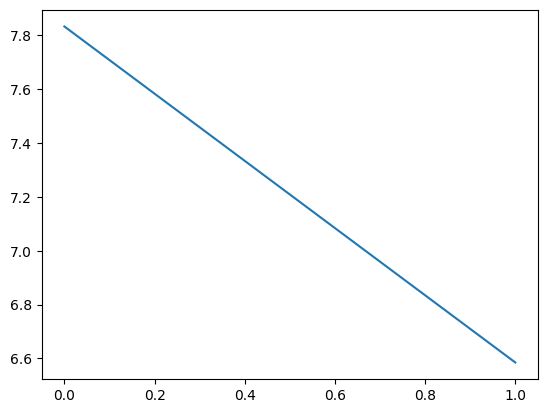

In [6]:
def enque_and_train(results):
    training_examples, reward, moves, high_square, pid = results
    training_examples = rotate_training_examples(training_examples)
    replay_memory.extend(training_examples)
    
    if replay_memory.size() >= hyperparameters.minibatch_size:
        value_loss, prob_loss, total_loss = train(replay_memory.sample(hyperparameters.minibatch_size), model, optimizer, tensor_conversion_fn=input_to_tensor_3d)
        new_best = metrics_history.add_history({
                'reward': reward,
                'game_moves': moves,
                'prob_loss': prob_loss,
                'value_loss': value_loss,
                'total_loss': total_loss,
                'high_square': high_square
            })
        metrics_history.plot_history(window_size=100)
        if new_best:
            print('*** NEW BEST REWARD ***')
        print(f'[EPISODE {metrics_history.episodes}] Total Loss: {total_loss}, Prob Loss {prob_loss}, Value Loss {value_loss}, Reward {reward}, Moves: {moves}, Highest Square: {high_square}, PID: {pid}')
        if metrics_history.episodes % hyperparameters.checkpoint_every == 0:
            print('Saving model checkpoint...')
            save_checkpoint(metrics_history.episodes, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag=run_tag, save_replay_memory=True)
            print('Saved model checkpoint!')
    else:
        print(f'Replay memory size not large enough, {replay_memory.size()} < {hyperparameters.minibatch_size}')
    
    
with mp.Pool(NUM_PROCS) as p:
    results = []
    for n in range(metrics_history.episodes, hyperparameters.num_episodes):
        results.append(p.apply_async(collect_episode, (model, hyperparameters, input_to_tensor_3d, ), callback=enque_and_train, error_callback=print))
    for r in results:
        r.wait()

In [ ]:
from env import _2048Env
from mcts import MCTS_Evaluator
import time

In [ ]:

def test():
    model = MonteCarlo3d()
    def to_tensor(data):
        return input_to_tensor_3d(data)

    env = _2048Env()
    env.reset()
    start_time = time.time()
    for _ in range(100):
        env.reset()
        mcts = MCTS_Evaluator(model, env, to_tensor, training=True)
        mcts.choose_progression(500)
    print('Without History', time.time() - start_time)

In [ ]:
# %prun -s tottime test()

Without History 50.10934591293335
 

         14018983 function calls (12805786 primitive calls) in 50.115 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   235325    8.255    0.000    8.255    0.000 {built-in method torch._C._nn.linear}
    94130    7.156    0.000    7.156    0.000 {built-in method torch.conv3d}
    94130    6.584    0.000    6.584    0.000 {built-in method torch.batch_norm}
170423/50000    3.587    0.000   47.795    0.001 mcts.py:62(iterate)
   170724    1.686    0.000    3.081    0.000 env.py:102(_get_obs)
   235325    1.560    0.000    1.560    0.000 {built-in method torch.relu}
941300/47065    1.515    0.000   33.746    0.001 module.py:1188(_call_impl)
    47065    1.483    0.000   33.599    0.001 model_3d.py:26(forward)
   853620    1.396    0.000    1.396    0.000 env.py:103(<genexpr>)
   120895    1.388    0.000    2.271    0.000 env.py:119(apply_move)
  1835603    0.953    0.000    0.953    0.000 module.py:1256(__getattr__)
    94130